## 使用 Keras 运行迁移学习 Inception V3 的机器学习程序





在这个项目中，我们基于叶片图像分类开发了一种植物病害识别模型。该程序使用基于 Keras 的迁移学习 Inception V3 算法。
所开发的模型能够识别 35 种不同类型的植物病害。它利用了 PlantVillage 提供的植物数据集。该程序挂载了我的的谷歌云端硬盘账户，数据集中的数据就存储在该账户中。然后，程序访问数据、训练模型、可视化训练结果，并最终输出一个以.H5 格式保存的训练数据。随后，将.H5 文件转换为.tflite 格式，以便能够在拉撒路・尼泊尔开发的安卓应用程序上运行。

## 挂载到驱动器

In [1]:
#挂载驱动器，以便程序可以在驱动器上执行读写操作。

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 导入模块并设置会话

In [2]:
#导入模块并配置会话和GPU选项

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
# 导入库

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
#import matplotlib.pyplot as plt

## 加载和预处理数据

In [4]:
# 调整所有图像的大小，使其尺寸统一
IMAGE_SIZE = [224, 224]

# 将训练集和验证集的路径分别赋值给相应的变量
train_path = '/content/drive/MyDrive/Plantvillage/train'
valid_path = '/content/drive/MyDrive/Plantvillage/val'


In [5]:
# 导入Inception V3库，并在VGG前面添加预处理层
# 使用ImageNet权重

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)




87916544/87910968 [==============================] - 1s 0us/step


In [6]:
# 不训练现有权重

for layer in inception.layers:
    layer.trainable = False        #冻结基础模型中的所有层

In [7]:
# 对于获取输出类别的数量很有用
folders = glob('/content/drive/MyDrive/Plantvillage/train/*')
folders

['/content/drive/MyDrive/Plantvillage/train/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 '/content/drive/MyDrive/Plantvillage/train/Apple___Apple_scab',
 '/content/drive/MyDrive/Plantvillage/train/Tomato___Early_blight']

## 构建模型

In [8]:
x = Flatten()(inception.output)

In [9]:
prediction = Dense(len(folders), activation='softmax')(x)

# 创建模型对象
model = Model(inputs=inception.input, outputs=prediction)

In [10]:
# 查看模型结构
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## 指定损失函数和优化器

In [11]:
# 告诉模型使用什么损失函数和优化方法
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


## 预训练

In [12]:
# 使用图像数据生成器从数据集导入图像
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
# 确保提供与初始化图像大小相同的目标大小
# 在训练前导入和配置训练数据
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Plantvillage/train',   
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1714 images belonging to 3 classes.


In [14]:
# 在训练前导入和配置验证数据
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Plantvillage/val',
                                            target_size = (224, 224),
                                            batch_size = 32,                # 为训练数据集分配RAM
                                            class_mode = 'categorical')

Found 429 images belonging to 3 classes.


## 训练

In [15]:
# 训练模型
# 运行此单元格。由于正在训练数据集，执行需要一些时间
# 数据集越大，训练模型所需时间越长
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=10,                 # 使用10个训练周期
  steps_per_epoch=len(training_set),
  #validation_steps=test_set.samples//test_set.batch_size
  validation_steps=len(test_set)
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
54/54 [==============================] - 422s 8s/step - loss: 4.2593 - accuracy: 0.6982 - val_loss: 0.1721 - val_accuracy: 0.9627
Epoch 2/10
54/54 [==============================] - 238s 4s/step - loss: 0.0354 - accuracy: 0.9904 - val_loss: 0.1032 - val_accuracy: 0.9814
Epoch 3/10
54/54 [==============================] - 237s 4s/step - loss: 0.0196 - accuracy: 0.9942 - val_loss: 0.1104 - val_accuracy: 0.9837
Epoch 4/10
54/54 [==============================] - 239s 4s/step - loss: 0.0156 - accuracy: 0.9954 - val_loss: 0.1311 - val_accuracy: 0.9767
Epoch 5/10
54/54 [==============================] - 242s 4s/step - loss: 0.0436 - accuracy: 0.9895 - val_loss: 0.1147 - val_accuracy: 0.9814
Epoch 6/10
54/54 [==============================] - 244s 5s/step - loss: 0.0057 - accuracy: 0.9978 - val_loss: 0.0901 - val_accuracy: 0.9790
Epoch 7/10
54/54 [==============================] - 244s 5s/step - loss: 0.0206 - accuracy: 0.9927 - val_loss: 0.1182 - val_accuracy: 0.9814
Epoch 8/10
54

## 通过可视化检查性能

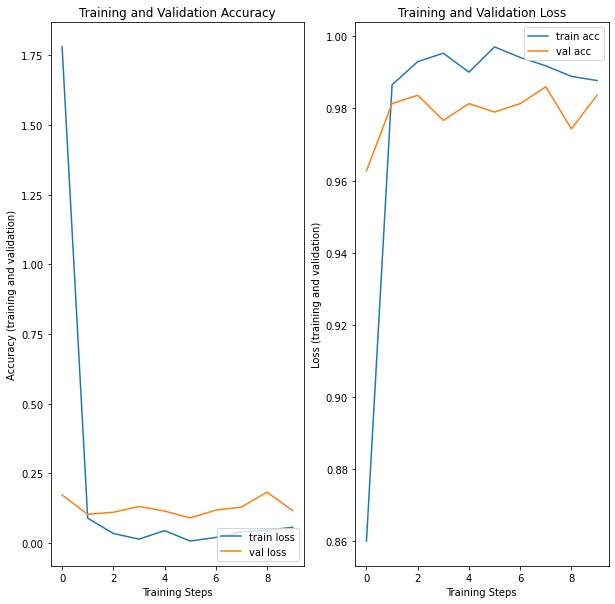

In [16]:
# 可视化训练输出

import matplotlib.pylab as plt
import numpy as np

acc = r.history['accuracy']
val_acc = r.history['val_accuracy']

loss = r.history['loss']
val_loss = r.history['val_loss']

epochs_range = range(32)


# 训练和验证准确率图表可视化
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(r.history['loss'], label='训练损失')
plt.plot(r.history['val_loss'], label='验证损失')
#plt.plot(epochs_range, acc, label='Training Accuracy')
#plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('训练和验证准确率')
plt.ylabel("准确率（训练和验证）")
plt.xlabel("训练步骤")

# 训练和验证损失图表可视化
plt.subplot(1, 2, 2)
plt.plot(r.history['accuracy'], label='训练准确率')
plt.plot(r.history['val_accuracy'], label='验证准确率')
#plt.plot(epochs_range, loss, label='Training Loss')
#plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('训练和验证损失')
plt.ylabel("损失（训练和验证）")
plt.xlabel("训练步骤")
plt.show()

## 以.h5格式保存模型

In [18]:
# 将输出保存为.h5文件扩展名

from tensorflow.keras.models import load_model

model.save('/content/drive/MyDrive/Plantvillage/model_inception.h5')

## 运行预测和numpy函数

In [19]:
# y_pred是一个监督估计器

y_pred = model.predict(test_set)
y_pred


array([[1.0000000e+00, 1.6051564e-22, 4.0012199e-10],
       [8.0432203e-11, 1.0000000e+00, 2.1444599e-08],
       [1.0000000e+00, 1.9111031e-26, 1.8975862e-16],
       ...,
       [9.0378300e-09, 8.7538635e-37, 1.0000000e+00],
       [5.3091707e-26, 1.0000000e+00, 9.6712365e-25],
       [1.0570603e-03, 4.5738709e-19, 9.9894291e-01]], dtype=float32)

In [20]:
#import numpy as np

# 返回特定轴上数组最大元素的索引
y_pred = np.argmax(y_pred, axis=1)
y_pred                         # 在np.argmax之后打印y_pred

array([0, 1, 0, 0, 1, 0, 1, 0, 0, 2, 1, 0, 2, 2, 2, 0, 2, 1, 0, 2, 0, 0,
       1, 2, 2, 0, 2, 2, 1, 0, 0, 2, 1, 1, 0, 0, 0, 1, 2, 0, 1, 2, 1, 2,
       2, 0, 1, 2, 0, 0, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 0, 2, 0, 2, 2, 1,
       1, 0, 1, 2, 0, 1, 2, 0, 1, 1, 2, 2, 1, 0, 1, 2, 1, 0, 0, 2, 0, 2,
       2, 0, 0, 2, 2, 1, 0, 1, 1, 1, 2, 1, 0, 2, 2, 0, 2, 2, 2, 0, 0, 1,
       2, 1, 1, 1, 2, 2, 2, 0, 0, 2, 1, 1, 2, 0, 2, 2, 2, 1, 2, 2, 2, 0,
       0, 0, 0, 0, 1, 0, 2, 2, 0, 1, 0, 0, 1, 2, 2, 2, 1, 2, 0, 2, 0, 0,
       0, 1, 2, 0, 2, 0, 0, 2, 2, 0, 1, 1, 2, 2, 0, 2, 1, 0, 0, 2, 2, 2,
       2, 2, 0, 2, 0, 0, 2, 2, 1, 0, 0, 2, 0, 2, 2, 0, 0, 1, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 0, 1, 2, 2, 1, 1, 1, 2, 1, 0,
       2, 2, 0, 2, 2, 2, 0, 0, 1, 2, 2, 0, 0, 2, 2, 2, 1, 0, 2, 0, 0, 2,
       2, 1, 1, 1, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 0, 2, 1, 2, 0, 0, 1,
       0, 2, 1, 2, 2, 2, 2, 1, 0, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 0, 1, 2,
       0, 0, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2,

## 随机测试

In [22]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [24]:
model=load_model('/content/drive/MyDrive/Plantvillage/model_inception.h5')       # 加载之前保存的.h5模型

In [25]:
# 测试图像样本

img=image.load_img('/content/drive/MyDrive/Plantvillage/val/Apple___Apple_scab/0a14783a-838a-4d4f-a671-ff98011714c6___FREC_Scab 3288.JPG',target_size=(224,224))

In [26]:
x=image.img_to_array(img)
x

array([[[113., 108., 131.],
        [125., 120., 143.],
        [113., 108., 131.],
        ...,
        [124., 119., 149.],
        [125., 120., 150.],
        [126., 121., 151.]],

       [[ 95.,  90., 113.],
        [103.,  98., 121.],
        [108., 103., 126.],
        ...,
        [120., 115., 145.],
        [118., 113., 143.],
        [117., 112., 142.]],

       [[133., 128., 151.],
        [118., 113., 136.],
        [107., 102., 125.],
        ...,
        [123., 118., 148.],
        [120., 115., 145.],
        [117., 112., 142.]],

       ...,

       [[ 80.,  76., 101.],
        [105., 101., 126.],
        [ 81.,  77., 102.],
        ...,
        [ 65.,  53.,  75.],
        [ 65.,  52.,  72.],
        [ 63.,  50.,  70.]],

       [[117., 113., 138.],
        [120., 116., 141.],
        [ 95.,  91., 116.],
        ...,
        [ 58.,  46.,  68.],
        [ 59.,  46.,  66.],
        [ 57.,  44.,  64.]],

       [[112., 108., 133.],
        [ 95.,  91., 116.],
        [108., 1

In [27]:
x.shape

(224, 224, 3)

In [28]:
x=x/255

In [29]:
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [30]:
model.predict(img_data)

array([[0.07815973, 0.00213591, 0.9197044 ]], dtype=float32)

In [31]:
img_data

array([[[[-0.9965244 , -0.9966782 , -0.9959708 ],
         [-0.9961553 , -0.9963091 , -0.9956017 ],
         [-0.9965244 , -0.9966782 , -0.9959708 ],
         ...,
         [-0.9961861 , -0.99633986, -0.9954171 ],
         [-0.9961553 , -0.9963091 , -0.99538636],
         [-0.99612457, -0.99627835, -0.9953556 ]],

        [[-0.99707806, -0.99723184, -0.9965244 ],
         [-0.996832  , -0.9969858 , -0.99627835],
         [-0.9966782 , -0.996832  , -0.99612457],
         ...,
         [-0.9963091 , -0.9964629 , -0.9955402 ],
         [-0.9963706 , -0.9965244 , -0.9956017 ],
         [-0.99640137, -0.99655515, -0.99563247]],

        [[-0.9959093 , -0.99606305, -0.9953556 ],
         [-0.9963706 , -0.9965244 , -0.995817  ],
         [-0.9967089 , -0.99686277, -0.9961553 ],
         ...,
         [-0.99621683, -0.9963706 , -0.99544793],
         [-0.9963091 , -0.9964629 , -0.9955402 ],
         [-0.99640137, -0.99655515, -0.99563247]],

        ...,

        [[-0.9975394 , -0.9976624 , -0

In [32]:
a=np.argmax(model.predict(img_data), axis=1)

In [33]:
a==1

array([False])

In [34]:
import tensorflow as tf

In [35]:
tf.__version__

'2.4.1'

## 导出为保存的模型并转换为TFLite

In [36]:
import tensorflow as tf
import time

export_path = "/content/drive/MyDrive/Plantvillage/model_inception.h5" # 或者您可以简单地使用'my_mode.h5'
model.save(export_path) # 保存您的模型


In [37]:
#from tensorflow.keras import Model

t = time.time()

export_path = "/content/drive/MyDrive/Plantvillage/saveModel/{}".format(int(t))
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Plantvillage/saveModel/1613836840/assets


'/content/drive/MyDrive/Plantvillage/saveModel/1613836840'

In [38]:
# 将模型转换为TFLite
!mkdir "/content/drive/MyDrive/Plantvillage/tflite_models"
TFLITE_MODEL = "/content/drive/MyDrive/Plantvillage/tflite_models/plant_disease_model.tflite"


# 从Keras模型获取具体函数
run_model = tf.function(lambda y : model(y)) 

# 保存具体函数
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# 将模型转换为标准TensorFlow Lite模型
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

87736892